In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai.utils.collect_env; fastai.utils.collect_env.show_install(1)



```text
=== Software === 
python        : 3.6.8
fastai        : 1.0.39
fastprogress  : 0.1.18
torch         : 1.0.0
nvidia driver : 396.44
torch cuda    : 9.0.176 / is available
torch cudnn   : 7401 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 8117MB | GeForce GTX 1070

=== Environment === 
platform      : Linux-4.4.0-21-generic-x86_64-with-debian-stretch-sid
distro        : #37-Ubuntu SMP Mon Apr 18 18:33:37 UTC 2016
conda env     : Unknown
python        : /home/ray/anaconda3/envs/fastai-please-work/bin/python
sys.path      : 
/home/ray/anaconda3/envs/fastai-please-work/lib/python36.zip
/home/ray/anaconda3/envs/fastai-please-work/lib/python3.6
/home/ray/anaconda3/envs/fastai-please-work/lib/python3.6/lib-dynload
/home/ray/anaconda3/envs/fastai-please-work/lib/python3.6/site-packages
/home/ray/anaconda3/envs/fastai-please-work/lib/python3.6/site-packages/IPython/extensions
/home/ray/.ipython

Sat Jan 12 19:22:50 2019       
+--------------------

In [3]:
from fastai.vision import *
from fastai.callbacks.hooks import *

In [4]:
defaults.device = 'cpu'

In [5]:
torch.cuda.set_device(0)

In [6]:
torch.cuda.is_available()

True

In [7]:
torch.backends.cudnn.enabled

True

In [8]:
path = Path('/home/ray/BDD/bdd100k/seg2_720')
path.ls()

[PosixPath('/home/ray/BDD/bdd100k/seg2_720/color_labels'),
 PosixPath('/home/ray/BDD/bdd100k/seg2_720/tmp'),
 PosixPath('/home/ray/BDD/bdd100k/seg2_720/images'),
 PosixPath('/home/ray/BDD/bdd100k/seg2_720/train-128'),
 PosixPath('/home/ray/BDD/bdd100k/seg2_720/labels'),
 PosixPath('/home/ray/BDD/bdd100k/seg2_720/models'),
 PosixPath('/home/ray/BDD/bdd100k/seg2_720/codes.txt'),
 PosixPath('/home/ray/BDD/bdd100k/seg2_720/train_masks-128')]

In [9]:
path_lbl = path/'color_labels/train'
path_img = path/'images/train'

In [10]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/ray/BDD/bdd100k/seg2_720/images/train/47406c52-6f9c5dbf.jpg'),
 PosixPath('/home/ray/BDD/bdd100k/seg2_720/images/train/b674bc13-3e309d54.jpg'),
 PosixPath('/home/ray/BDD/bdd100k/seg2_720/images/train/444450f8-eb43d2b7.jpg')]

In [11]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/ray/BDD/bdd100k/seg2_720/color_labels/train/3f8b781f-38cbe876_train_color.png'),
 PosixPath('/home/ray/BDD/bdd100k/seg2_720/color_labels/train/7a0ba545-3961a92c_train_color.png'),
 PosixPath('/home/ray/BDD/bdd100k/seg2_720/color_labels/train/4e8a3e02-00000000_train_color.png')]

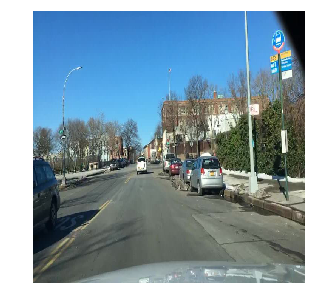

In [12]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [13]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_train_color.png'

In [14]:
print(get_y_fn)

<function <lambda> at 0x7fb7d5d3a8c8>


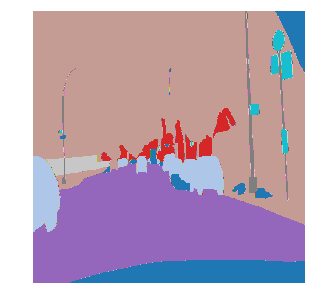

In [15]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [16]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 720]), tensor([[[117, 117, 117,  ...,   0,   0,   0],
          [117, 117, 117,  ...,   0,   0,   0],
          [117, 117, 117,  ...,   0,   0,   0],
          ...,
          [ 90,  90,  90,  ...,   0,   0,   0],
          [ 90,  90,  90,  ...,   0,   0,   0],
          [ 90,  90,  90,  ...,   0,   0,   0]]]))

In [17]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['traffic_light', 'traffic_sign', 'car', 'drivable_area', 'lane', 'person', 'bus', 'truck', 'rider', 'bike',
       'motor', 'train'], dtype='<U13')

# TEST

In [18]:
size = src_size//2
bs=8

In [19]:
#NOTE: Validation set had same name as training. Also, training set is from same folder as validation
#make backup copy of images + validation folder, move all files from old validation to images folder

#TODO: label =/= n_classes
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [20]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

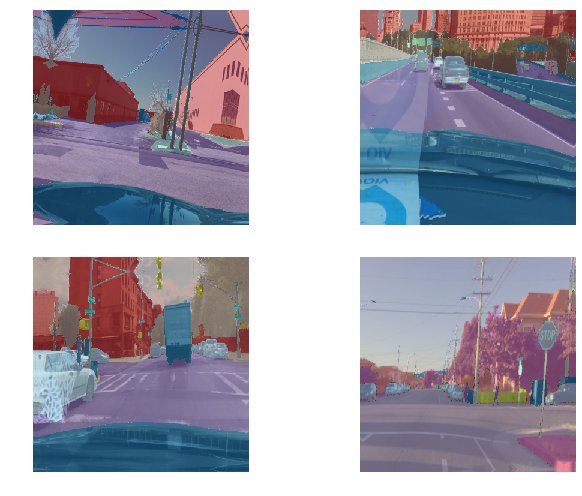

In [21]:
data.show_batch(2, figsize=(10,7))

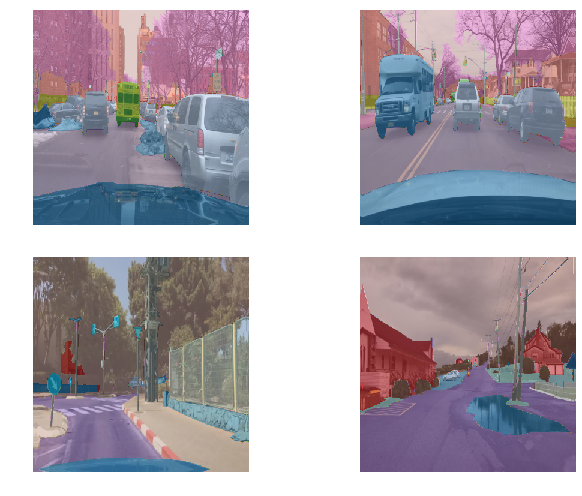

In [22]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

In [23]:
name2id = {v:k for k,v in enumerate(codes)}
# void_code = name2id['void']

def dice(pred, targs):
    pred = (pred>0).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

def iou(input:Tensor, targs:Tensor) -> Rank0Tensor:
    "IoU coefficient metric for binary target."
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    intersect = (input*targs).sum().float()
    union = (input+targs).sum().float()
    return intersect / (union-intersect+1.0)

# def accuracy(input, target):
#     target = target.squeeze(1)
#     mask = target != void_code
#     return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [24]:
# metrics=dice
metrics = accuracy

In [25]:
wd=1e-2

In [29]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)
print("data:", data)

data: ImageDataBunch;

Train: LabelList
y: SegmentationLabelList (6361 items)
[ImageSegment (1, 720, 720), ImageSegment (1, 720, 720), ImageSegment (1, 720, 720), ImageSegment (1, 720, 720), ImageSegment (1, 720, 720)]...
Path: /home/ray/BDD/bdd100k/seg2_720/images/train
x: SegmentationItemList (6361 items)
[Image (3, 720, 720), Image (3, 720, 720), Image (3, 720, 720), Image (3, 720, 720), Image (3, 720, 720)]...
Path: /home/ray/BDD/bdd100k/seg2_720/images/train;

Valid: LabelList
y: SegmentationLabelList (639 items)
[ImageSegment (1, 720, 720), ImageSegment (1, 720, 720), ImageSegment (1, 720, 720), ImageSegment (1, 720, 720), ImageSegment (1, 720, 720)]...
Path: /home/ray/BDD/bdd100k/seg2_720/images/train
x: SegmentationItemList (639 items)
[Image (3, 720, 720), Image (3, 720, 720), Image (3, 720, 720), Image (3, 720, 720), Image (3, 720, 720)]...
Path: /home/ray/BDD/bdd100k/seg2_720/images/train;

Test: None


# DEBUGGING

In [27]:
print("learn:", learn[:10])

TypeError: 'Learner' object is not subscriptable

In [28]:
lr_find(learn)
learn.recorder.plot()

# Assertion `cur_target >= 0 && cur_target < n_classes' failed.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: Assertion `cur_target >= 0 && cur_target < n_classes' failed.  at /opt/conda/conda-bld/pytorch_1544174967633/work/aten/src/THNN/generic/ClassNLLCriterion.c:93